# Smoothing in Time Series

**Author:** Michael Childress  
**Date:** 2025‑04‑18 

_In this notebook we’ll define smoothing, explore simple and exponential smoothing techniques, and see how to use them in Python for forecasting. Each section pairs runnable code with a brief discussion of the results._

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import os

# Utility plotting function
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Value"):
    fig, ax = plt.subplots(figsize=(10,3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

# Make sure plots folder exists
plots_dir = './plots'
os.makedirs(plots_dir, exist_ok=True)

# MSE function (from previous notebook)
def mse(observations, estimates):
    obs = np.array(observations)
    est = np.array(estimates)
    return np.mean((obs - est)**2)

Generating Synthetic Data

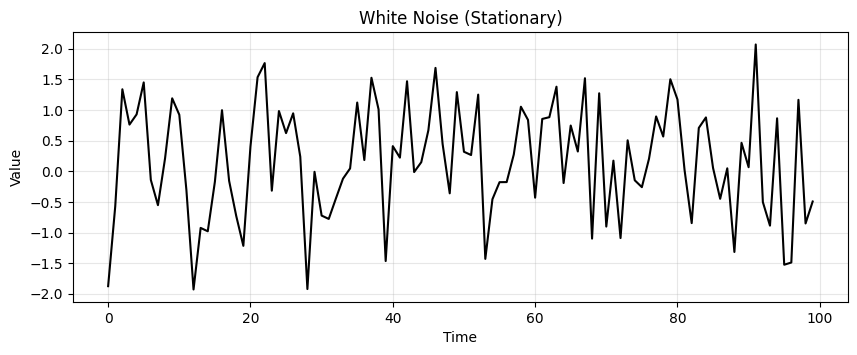

In [25]:
# Create a stationary white-noise series
T = 100
time = np.arange(T)
stationary = np.random.normal(loc=0, scale=1.0, size=T)
ax = run_sequence_plot(time, stationary, title="White Noise (Stationary)")
plt.savefig(f"{plots_dir}/white_noise.png")
plt.show()

**Discussion: White Noise**  
- Fluctuates randomly around zero; variance is constant.  
- No trend or seasonality—ideal stationary baseline for smoothing methods.

**Simple Average**

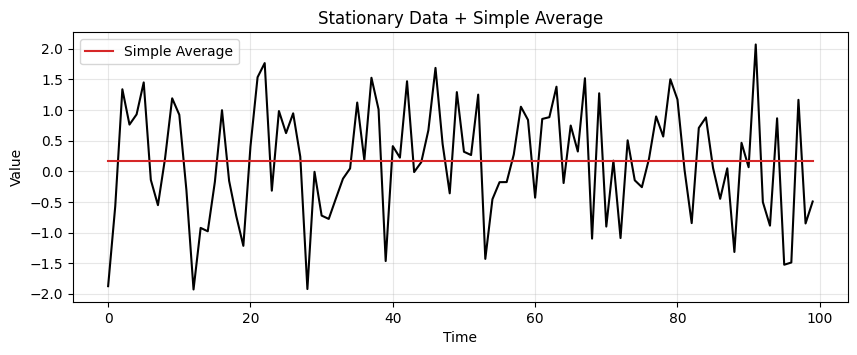

MSE simple average: 0.848906407045608


In [26]:
# Simple average forecast = constant mean
mean_val = stationary.mean()
flat_pred = np.full_like(stationary, fill_value=mean_val)

# Plot
ax = run_sequence_plot(time, stationary, title="Stationary Data + Simple Average")
ax.plot(time, flat_pred, 'tab:red', label="Simple Average")
ax.legend()
plt.savefig(f"{plots_dir}/simple_average.png")
plt.show()

# Compute MSE
print("MSE simple average:", mse(stationary, flat_pred))

**Discussion: Simple Average**  
- Uses a single constant to represent all future values.  
- Works only for perfectly stationary data.  
- MSE quantifies how well (or poorly) this trivial model fits.

**Moving Average**

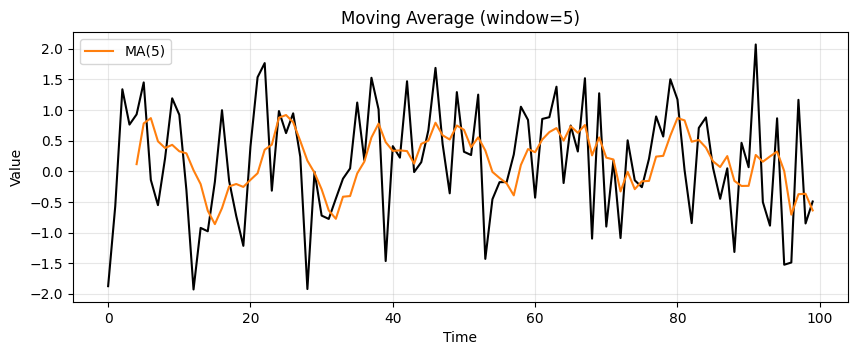

MSE MA(5): 0.654314181740186


In [27]:
def moving_average(obs, window):
    cumsum = np.cumsum(obs, dtype=float)
    cumsum[window:] = cumsum[window:] - cumsum[:-window]
    return cumsum[window-1:] / window

# Apply MA to stationary with window=5
ma5 = moving_average(stationary, window=5)
t_ma5 = time[4:]

# Plot
ax = run_sequence_plot(time, stationary, title="Moving Average (window=5)")
ax.plot(t_ma5, ma5, 'tab:orange', label="MA(5)")
ax.legend()
plt.savefig(f"{plots_dir}/ma5_stationary.png")
plt.show()

print("MSE MA(5):", mse(stationary[4:], ma5))

**Discussion: Moving Average**  
- Smooths out short-term noise by averaging over a fixed window.  
- More responsive than simple average but introduces a lag of (window–1)/2 steps.  
- Choice of window trades off noise reduction vs. responsiveness.

**Weighted Moving Average**

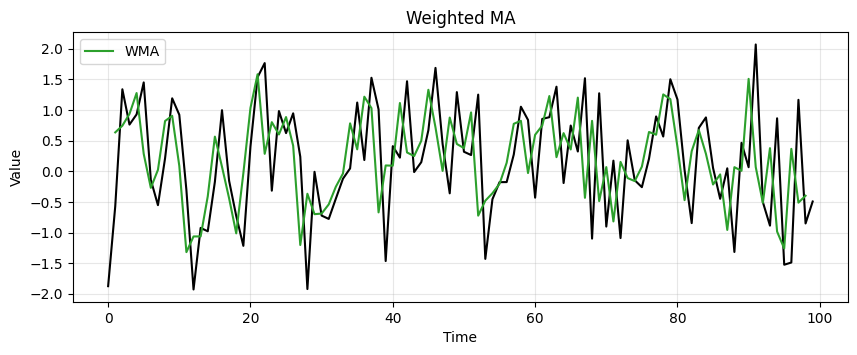

In [28]:
def weighted_moving_average(obs, weights):
    w = np.array(weights)/sum(weights)
    half = len(w)//2
    result = np.full_like(obs, np.nan, dtype=float)
    for i in range(half, len(obs)-half):
        result[i] = np.dot(obs[i-half:i+half+1], w)
    return result

# Example weights and application
weights = [0.1, 0.2, 0.7]
wma = weighted_moving_average(stationary, weights)

# Plot
ax = run_sequence_plot(time, stationary, title="Weighted MA")
ax.plot(time, wma, 'tab:green', label="WMA")
ax.legend()
plt.savefig(f"{plots_dir}/wma_stationary.png")
plt.show()

**Discussion: Weighted Moving Average**  
- Assigns greater importance to recent observations via custom weights.  
- Reduces lag compared to equal‑weight MA.  
- Weight choice offers more flexibility but requires calibration.

**Exponential Smoothing**

Single

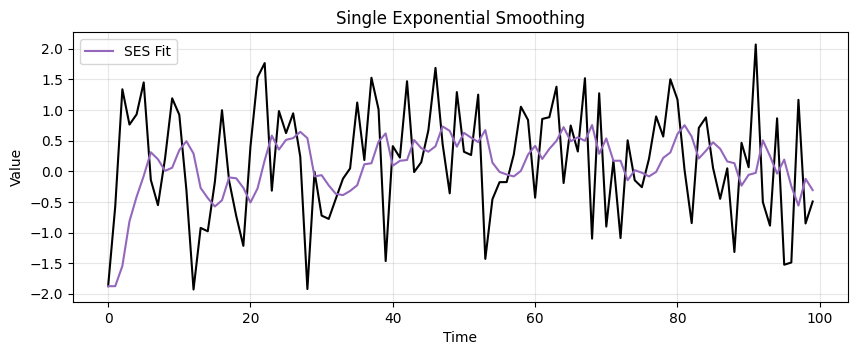

In [29]:
# Single ES on stationary
ses = SimpleExpSmoothing(stationary).fit(optimized=True)
ses_fit = ses.fittedvalues
ax = run_sequence_plot(time, stationary, title="Single Exponential Smoothing")
ax.plot(time, ses_fit, 'tab:purple', label="SES Fit")
ax.legend()
plt.savefig(f"{plots_dir}/ses_stationary.png")
plt.show()

**Discussion: Single Exponential Smoothing**  
- Similar to WMA with exponentially decaying weights.  
- Good baseline when no trend or seasonality is present.  
- Smooths noise while adapting more quickly than MA.

Double (Holt's)

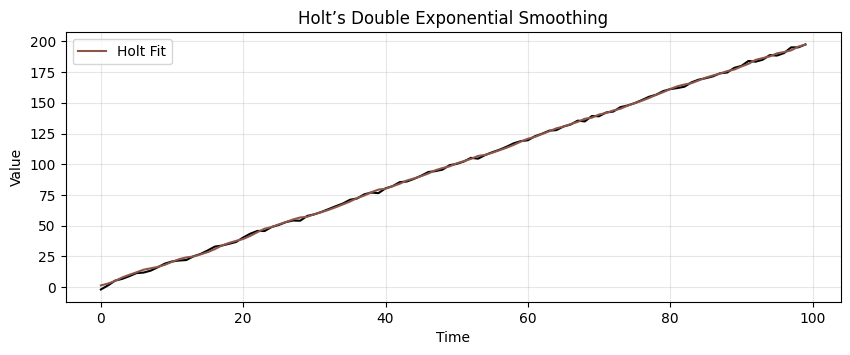

In [30]:
# Add trend to data for demo
trend_series = 2.0 * time + stationary

# Holt’s method
holt = Holt(trend_series).fit(optimized=True)
holt_fit = holt.fittedvalues

ax = run_sequence_plot(time, trend_series, title="Holt’s Double Exponential Smoothing")
ax.plot(time, holt_fit, 'tab:brown', label="Holt Fit")
ax.legend()
plt.savefig(f"{plots_dir}/holt_trend.png")
plt.show()

**Discussion: Double Exponential Smoothing**  
- Captures both level and trend components.  
- Forecasts follow an estimated trend line rather than a horizontal mean.  
- Ideal when a linear trend is present.

Triple (Holt-Winters)

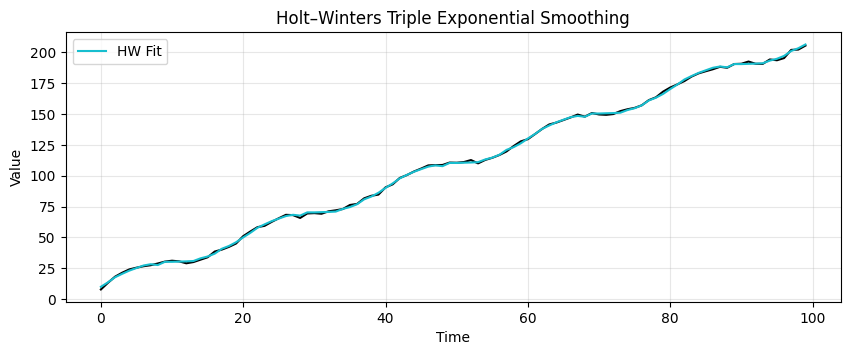

In [31]:
# Create a seasonal + trend series
seasonal = 10 + 5 * np.sin(2*np.pi*time/20)
ts = trend_series + seasonal + np.random.normal(0,0.5,T)

hw = ExponentialSmoothing(ts, trend="add", seasonal="add", seasonal_periods=20).fit(optimized=True)
hw_fit = hw.fittedvalues

ax = run_sequence_plot(time, ts, title="Holt–Winters Triple Exponential Smoothing")
ax.plot(time, hw_fit, 'tab:cyan', label="HW Fit")
ax.legend()
plt.savefig(f"{plots_dir}/hw_ts.png")
plt.show()

**Discussion: Triple Exponential Smoothing (Holt–Winters)**  
- Models level, trend, and seasonality simultaneously.  
- Forecasts inherit periodic patterns and trending behavior.  
- Superior for data with stable seasonal cycles.

**Forecast Comparison**

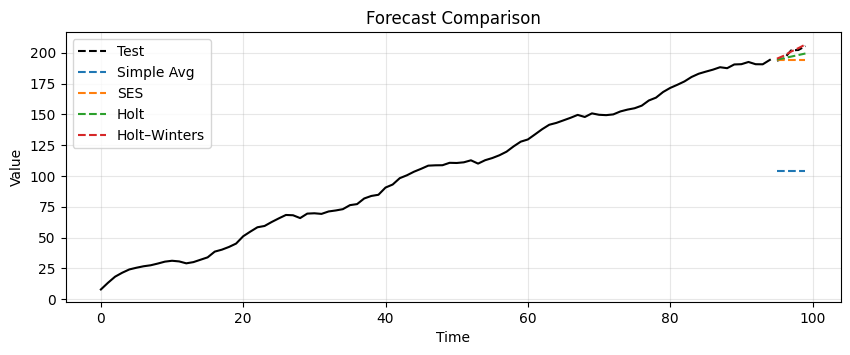

In [32]:
# Train/test split on ts
train, test = ts[:-5], ts[-5:]
models = {
    "Simple Avg": np.full(len(test), train.mean()),
    "SES": SimpleExpSmoothing(train).fit(optimized=True).forecast(len(test)),
    "Holt": Holt(train).fit(optimized=True).forecast(len(test)),
    "Holt–Winters": ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=20).fit(optimized=True).forecast(len(test))
}
results = {name: mse(test, pred) for name, pred in models.items()}

# Display MSE table
pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])

# Plot forecasts
ax = run_sequence_plot(np.arange(len(train)), train, title="Forecast Comparison")
ax.plot(np.arange(len(train), len(train)+len(test)), test, 'k--', label="Test")
for name, pred in models.items():
    ax.plot(np.arange(len(train), len(train)+len(test)), pred, '--', label=name)
ax.legend()
plt.savefig(f"{plots_dir}/forecast_comparison.png")
plt.show()

**Discussion: Forecast MSE & Plots**  
- Compare each method’s test‑set MSE side by side.  
- **Holt–Winters** typically wins when both trend and seasonality exist.  
- Use these metrics to choose your smoothing model in production.